In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import tensorflow as tf
# import tensorflow_probability as tfp
# import gpytorch
# from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.callbacks import Callback
from scipy.stats import gamma, norm, beta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,  MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings


### Dataset

In [3]:
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

### Functions_try

In [4]:
def linUCB(alpha, X, generate_reward, true_theta):
    '''
    alpha: higher alpha encourages more exploration / lower alpha focuses on exploitation
    X: The feature matrix, where each row represents the context (features) for a trial
    generate_reward: A function that generates the reward for selecting an arm at a given trial
    true_theta: The true underlying parameters of the system
    '''
    
    print("linUCB with alpha: ", alpha)
    n_trial, n_feature = X.shape
    n_arms = true_theta.shape[0]  # Infer number of arms from true_theta
    
    # 1. Initialise object
    arm_choice, r_payoff = [np.empty(n_trial) for _ in range(2)]

    '''
    theta: Stores the estimated parameters (reward function) for each arm at each trial
    Each slice theta[t, a, :] represents the estimated parameters for arm a at trial t
    p: Stores the upper confidence bound (UCB) values for each arm at each trial
    '''
    theta  = np.empty(shape=(n_trial, n_arms, n_feature))
    p      = np.empty(shape=(n_trial, n_arms))
    
    # 1.2 Intermediate object
    # covariance matrix
    A = np.array([np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    # accumulates the weighted sum of observed rewards
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

    # 2. Algo
    for t in np.arange(n_trial):
        
        # Compute estimates (theta) and prediction (p) for all arms with the same context X[t]
        for a in np.arange(n_arms):
            inv_A       = np.linalg.inv(A[a])
            # Estimated parameters
            theta[t, a] = inv_A.dot(b[a])
            # UCB
            p[t, a]     = theta[t, a].dot(X[t]) + alpha * np.sqrt(X[t].dot(inv_A).dot(X[t]))
        
        # Choose best arm
        chosen_arm    = np.argmax(p[t])
        x_chosen_arm  = X[t]  # Same context for all arms
        
        # Use trial number t in the reward function
        r_payoff[t]   = generate_reward(t=t, arm=chosen_arm, x=x_chosen_arm, base_theta=true_theta)
        arm_choice[t] = chosen_arm
        
        # Update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[t] * x_chosen_arm
    
    return dict(theta=theta, p=p, arm_choice=arm_choice, r_payoff=r_payoff)

In [5]:
# Reward function
def generate_reward(t, arm, x, base_theta, scale_noise=0.1):
    """Generate the reward in a dynamic environment."""
    oscillation = 0.2 * np.sin(t / 10) + 0.1 * np.cos(t / 15)  # Combined oscillation
    dynamic_theta = base_theta[arm] + oscillation  # Dynamic perturbation
    normal_mean = dynamic_theta.dot(x) + (0.3 if arm == 2 else 0)  # Bias for arm 1
    normal_stddev = np.maximum(0.1, np.abs(dynamic_theta.dot(x)))  # Volatility
    noise = norm.rvs(loc=normal_mean, scale=normal_stddev * scale_noise)
    return normal_mean + noise

In [6]:
def generate_reward_v2(t, arm, x, base_theta, scale_noise=0.1):
    """
    Generate the reward in a dynamic environment using a linear and nonlinear approach.

    Parameters:
        t (int): The current time step.
        arm (int): The index of the arm being pulled.
        x (np.ndarray): Feature vector associated with the arm.
        base_theta (np.ndarray): Base parameters for each arm.
        scale_noise (float): Scaling factor for noise (default is 0.1).

    Returns:
        float: The generated reward.
    """
    # Validate parameters
    if arm < 0 or arm >= len(base_theta):
        raise ValueError("Arm index is out of bounds.")
    if x.ndim != 1 or x.shape[0] != base_theta.shape[1]:
        raise ValueError("Feature vector x must match the dimensionality of base_theta.")

    # Linear component influenced by time
    linear_component = base_theta[arm].dot(x) * (1 + 0.1 * np.sin(t / 5))
    
    # Nonlinear oscillation based on the arm index
    nonlinear_component = 0.2 * (arm + 1) * np.sin(t / 7)

    # Calculate the normal mean and standard deviation
    normal_mean = linear_component + nonlinear_component
    normal_stddev = np.maximum(0.1, np.abs(normal_mean) * scale_noise)

    # Generate noise
    noise = norm.rvs(loc=normal_mean, scale=normal_stddev)
    
    return normal_mean + noise

In [7]:
def make_theta(n_arms, n_features):
    true_theta = np.random.normal(0, 1, (n_arms, n_features))
    return true_theta

# Generate optimal arms based on true_theta
def optimal_arm(X, true_theta):
    optimal_arms = []
    for t in range(X.shape[0]):
        rewards = [generate_reward(t, arm, X[t], true_theta) for arm in range(n_arms)]
        optimal_arms.append(np.argmax(rewards))
    return np.array(optimal_arms)

def make_regret(payoff, oracle):
    """Calculate the cumulative regret between the payoff and the oracle."""
    payoff = np.array(payoff)
    oracle = np.array(oracle)
    return np.cumsum(oracle - payoff)


In [8]:
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x["r_payoff"], oracle = oracle), label = "alpha: " + str(alpha)) \
     for (alpha, x) in results.items()]
    
def plot_estimates(x, alpha, true_theta=None, abs_ylim = None, ncol = 4):
    print("Esimates plot for alpha: ", alpha)
    if true_theta is not None:
            print("Parameter true_theta has been supplied. Plotting convergence")
    for i, arm in enumerate(np.arange(n_arms)):
        plt.subplot(int(np.ceil(n_arms / ncol)), ncol, 1 + i)
       
        if true_theta is not None:
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) - true_theta[arm]
        else : 
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) 
        plt.plot(data_to_plot)
        plt.hlines(y=0, xmin = 0, xmax = n_trial, linestyles=":")
        
        if (arm in best_arms) :
            title = "Arm: " + str(arm) + " (best)"
        else :
            title = "Arm: " + str(arm) 
        plt.title(title)
        if abs_ylim is not None :
            plt.ylim([-abs_ylim, abs_ylim])
    plt.legend(["c" + str(feature) for feature in np.arange(n_features)])   
    
def plot_selected_arms(x, bar_width = .15):
    for (i, alpha) in enumerate(x):
        xi, yi = np.unique(x[alpha]["arm_choice"], return_counts=True)
        plt.bar(xi + i * bar_width, yi, label="alpha: " + str(alpha), width=bar_width)

    plt.xticks(np.arange(n_arms) + round(len(x)/2) * bar_width, np.arange(n_arms))
    plt.legend()    

In [9]:
# Function to compute accuracy and F1 score for each alpha level
def calculate_accuracy_f1(results, optimal_arms):
    accuracy_scores = {}
    f1_scores = {}
    
    for alpha, res in results.items():
        # Extract the chosen arms
        chosen_arms = res['arm_choice']
        
        # Calculate accuracy: proportion of correctly chosen arms
        accuracy = accuracy_score(optimal_arms, chosen_arms)
        accuracy_scores[alpha] = accuracy
        
        # Calculate F1 score (binary classification, assuming two arms: 0 and 1)
        f1 = f1_score(optimal_arms, chosen_arms, average='weighted')
        f1_scores[alpha] = f1
    
    return accuracy_scores, f1_scores

## 1. Data preprocess

In [10]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
data = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets.values - 1 ## 1 subtracted for (0 = Good,  1 = Bad) labelling
  
# metadata 
#print(statlog_german_credit_data.metadata) 
  
# variable information 
#print(statlog_german_credit_data.variables) 

In [11]:
statlog_german_credit_data.variables

,name,role,type,demographic,description,units,missing_values
0,Attribute1,Feature,Categorical,None,Status of existing checking account,None,no
1,Attribute2,Feature,Integer,None,Duration,months,no
2,Attribute3,Feature,Categorical,None,Credit history,None,no
3,Attribute4,Feature,Categorical,None,Purpose,None,no
4,Attribute5,Feature,Integer,None,Credit amount,None,no
5,Attribute6,Feature,Categorical,None,Savings account/bonds,None,no
6,Attribute7,Feature,Categorical,Other,Present employment since,None,no
7,Attribute8,Feature,Integer,None,Installment rate in percentage of disposable i...,None,no
8,Attribute9,Feature,Categorical,Marital Status,Personal status and sex,None,no
9,Attribute10,Feature,Categorical,None,Other debtors / guarantors,None,no


In [12]:
df=data[statlog_german_credit_data.variables.name[:-1]]
df_full=df.copy()
df_full.columns=statlog_german_credit_data.variables.description[:-1].to_list()
df_full

,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


In [13]:
# Define preprocessing steps
numeric_features = ['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
binary_features = ['Attribute19', 'Attribute20']
categorical_features = ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17']

# Apply LabelEncoder to binary features
label_encoders = {}
for feature in binary_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le  # Store the encoder for future use (e.g., inverse transform)

# Pipeline for numeric features: Imputation and Min-Max Scaling between -1 and 1
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

# Pipeline for categorical features: Imputation, OneHotEncoding, and Min-Max Scaling between -1 and 1
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),  # Set sparse=False for easy concatenation
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))  # Scaling the one-hot encoded features
])

# For binary features, use Min-Max Scaling as well
binary_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ]
)

# Apply the preprocessing steps to the DataFrame
df2 = preprocessor.fit_transform(df)

# If you want to convert it back to a DataFrame for ease of use
# Create column names for the one-hot encoded features
onehot_feature_names = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out())

# Combine all feature names
all_feature_names = numeric_features + onehot_feature_names + binary_features

# Create the processed DataFrame
df2 = pd.DataFrame(df2, columns=all_feature_names)

# Show the processed DataFrame
df2


,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18,x0_A11,x0_A12,x0_A13,...,x8_A143,x9_A151,x9_A152,x9_A153,x10_A171,x10_A172,x10_A173,x10_A174,Attribute19,Attribute20
0,-0.941176,-0.898867,1.000000,1.000000,0.714286,-0.333333,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
1,0.294118,-0.372620,-0.333333,-0.333333,-0.892857,-1.000000,-1.0,-1.0,1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,-0.764706,-0.796853,-0.333333,0.333333,0.071429,-1.000000,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
3,0.117647,-0.160119,-0.333333,1.000000,-0.071429,-1.000000,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,-0.411765,-0.491581,0.333333,1.000000,0.214286,-0.333333,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.764706,-0.836470,0.333333,1.000000,-0.571429,-1.000000,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
996,-0.235294,-0.603059,1.000000,1.000000,-0.250000,-1.000000,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
997,-0.764706,-0.939034,1.000000,1.000000,-0.321429,-1.000000,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
998,0.205882,-0.824475,1.000000,1.000000,-0.857143,-1.000000,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0


## 2. Define functions

In [14]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(42)

In [15]:
# RewardGenerator and generate_data functions (from your code)
class RewardGenerator:
    def __init__(self, drift_rate=0.005, seasonal_period=400):
        self.drift_rate = drift_rate
        self.seasonal_period = seasonal_period
        self.t = 0  # Initialize time step

    def generate_rewards(self, context, action, optimal_action, n=3):
        """
        Generates rewards with added complexity from context sampling and non-stationarity.

        Parameters:
        - context: np.array, the feature context
        - action: int, the action taken
        - optimal_action: int, the optimal action for this context
        - n: int, number of context features to sample for reward generation

        Returns:
        - reward: float, the generated reward
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than n
        
        # Compute a context factor based on the sampled features
        context_factor = np.sum(sampled_context)
        
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)

        # Calculate reward based on action and non-stationary factors
        if action == optimal_action:
            mean = 1 + 0.2 * context_factor + time_drift + seasonality
            std = 0.1  # Small variance for optimal action
        else:
            mean = 0 + 0.5 * context_factor + time_drift + seasonality
            std = 0.4  # Higher variance for non-optimal action
        
        # Sample reward from Gaussian distribution
        reward = np.random.normal(mean, std)

        # Increment time step for next call
        self.t += 1
        
        return reward

    
    def generate_rewards_polynomial(self, context, action, optimal_action, n=3):
        """
        Non-linear polynomial reward generation with context sampling and non-stationarity.
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than `n`
        
        # Calculate polynomial context factor
        context_factor = np.sum(sampled_context) 
        
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)
    
        # Polynomial-based reward scaling (quadratic)
        base_reward = 0.01 * context_factor**2 + time_drift + seasonality
    
        # Modify reward based on whether the action is optimal or not
        if action == optimal_action:
            reward = 1 + 0.1 * base_reward  # High reward for optimal action
        else:
            reward = 0.5 * base_reward  # Reduced reward for non-optimal action
    
        # Increment time step for next call
        self.t += 1
    
        return reward


    def generate_rewards_tanh(self, context, action, optimal_action, n=3):
        """
        Non-linear tanh reward generation with context sampling and non-stationarity.
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than `n`
        
        # Compute a context factor based on the sampled features
        context_factor = np.sum(sampled_context)
    
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)
    
        # Tanh-based reward scaling
        base_reward = np.tanh(0.1 * context_factor + time_drift + seasonality)
    
        # Scale reward to fit a desired range
        if action == optimal_action:
            reward = 1 * (base_reward + 1) / 2  # High reward for optimal action (0 to 1 range)
        else:
            reward = 0.5 * (base_reward + 1) / 2  # Reduced reward for non-optimal action (0 to 1 range)
    
        # Increment time step for next call
        self.t += 1

        return reward

    def generate_rewards_relu(self, context, action, optimal_action, n=3):
        """
        Generates rewards using a ReLU-based function for non-negative reward scaling.
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than n

        # Compute a context factor based on the sampled features
        context_factor = np.sum(sampled_context)

        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)

        # ReLU-based reward scaling
        base_reward = max(0, context_factor) + time_drift + seasonality

        # Modify reward based on whether the action is optimal or not
        if action == optimal_action:
            reward = 1 + 0.5 * base_reward  # High reward for optimal action
        else:
            reward = 0.5 * base_reward  # Reduced reward for non-optimal action

        # Increment time step for next call
        self.t += 1

        return reward


In [16]:
# Example usage in your data generation function
def generate_data(context, total_samples, n_actions, optimal_actions, reward_type):
    rewards = torch.zeros(total_samples, n_actions)
    
    reward_gen = RewardGenerator()

    for i in range(total_samples):
        for action in range(n_actions):
            # Generate rewards based on the given logic
            if reward_type == 'linear':
                rewards[i, action] = reward_gen.generate_rewards(context[i], action,  optimal_actions[i])
            elif reward_type == 'poly':
                rewards[i, action] = reward_gen.generate_rewards_polynomial(context[i], action,  optimal_actions[i])
            elif reward_type == 'tanh':
                rewards[i, action] = reward_gen.generate_rewards_tanh(context[i], action,  optimal_actions[i])
            elif reward_type == 'relu':
                rewards[i, action] = reward_gen.generate_rewards_relu(context[i], action,  optimal_actions[i])              

    return rewards


# Function to generate actions from a normal distribution and clip them to valid action range
def generate_actions(total_samples):
    return  np.random.choice([0, 1], size=total_samples)


# Define the data generation and splitting function
def generate_data_and_split(X, total_samples, n_actions, optimal_actions, reward_type):
    
    rewards = generate_data(X, total_samples, n_actions, optimal_actions, reward_type)
    split_index = int(total_samples * 0.9)
    X_train = X[:split_index]
    historical_actions = generate_actions(split_index)
    historical_rewards = rewards[:split_index]
    
    X_val = X[split_index:]
    optimal_actions_val = optimal_actions[split_index:]
    rewards_val = rewards[split_index:]
    
    return X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val

## 3. LinUCB

In [17]:
class LinUCB:
    def __init__(self, n_actions, context_dim, alpha=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha

        # Initialize A as identity matrices for each action
        self.A = [np.eye(context_dim) for _ in range(n_actions)]

        # Initialize b as zero arrays for each action
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]

    def update(self, action, reward, context):
        context = np.array(context)

        # Ensure context shape matches b[action]
        if context.shape != self.b[action].shape:
            raise ValueError(f"Context shape {context.shape} does not match expected shape {self.b[action].shape}")

        # Update A and b using outer product of context
        self.A[action] += np.outer(context, context)

        # Convert reward to a scalar if it's a zero-dimensional tensor
        if isinstance(reward, torch.Tensor) and reward.ndim == 0:
            reward = reward.item()

        # Now reward is guaranteed to be a scalar
        self.b[action] += reward * context

    def predict(self, contexts):
        contexts = np.array(contexts)
        preds = np.zeros((contexts.shape[0], self.n_actions))

        for i, context in enumerate(contexts):
            for action in range(self.n_actions):
                A_inv = np.linalg.inv(self.A[action])
                theta = A_inv @ self.b[action]
                preds[i, action] = context @ theta + self.alpha * np.sqrt(context @ A_inv @ context.T)

        return preds

In [18]:
def plot_optimal_vs_linucb(optimal_actions, linucb_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(linucb_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(linucb_actions, bins=bins, edgecolor='black', alpha=0.5, label='LinUCB Actions')
    
    plt.title('Comparison of Optimal Actions vs LinUCB Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Backtest

In [19]:
def run_backtest(X, total_samples, n_actions, optimal_actions, context_dim, num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=20,reward_type ='linear'):
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
       X, total_samples, n_actions, optimal_actions, reward_type)

    # Convert PyTorch tensors to NumPy arrays if needed
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().numpy()
    if isinstance(X_val, torch.Tensor):
        X_val = X_val.detach().numpy()
    if isinstance(historical_rewards, torch.Tensor):
        historical_rewards = historical_rewards.detach().numpy()
    if isinstance(historical_actions, torch.Tensor):
        historical_actions = historical_actions.detach().numpy()


     # LinUCB
    lin_UCB_model = LinUCB(n_actions, context_dim, alpha=0.5)
    for i in range(len(historical_actions)):
        lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])

    lin_UCB_preds = lin_UCB_model.predict(X_val)
    lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)

    # Generate true rewards based on optimal actions
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    
    reward_gen = RewardGenerator()
    
    for action in range(n_actions):
        for i, opt_action in enumerate(optimal_actions_val):
            if reward_type == 'linear':
                all_true_rewards[i, action] =  reward_gen.generate_rewards(X_val[i], action, opt_action)
            elif reward_type == 'poly':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_polynomial(X_val[i], action, opt_action)
            elif reward_type == 'tanh':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_tanh(X_val[i], action, opt_action)
            elif reward_type == 'relu':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_relu(X_val[i], action, opt_action)

    
    true_rewards = np.max(all_true_rewards, axis=1)
    lin_UCB_rewards = np.array([all_true_rewards[i, lin_UCB_preds[i]] for i in range(len(lin_UCB_preds))])

    plt.figure(figsize=(12, 5))
    plt.plot(np.cumsum(true_rewards), label='Optimal Policy', linestyle='--')
    plt.plot(np.cumsum(lin_UCB_rewards), label='Lin_UCB Strategy')

    plt.title(f'Cumulative Rewards with {reward_type} reward')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()

    plot_optimal_vs_linucb(optimal_actions_val, lin_UCB_preds)

    print(f"LinUCB Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
    print(f"LinUCB F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")


In [20]:
# Example usage
X=df2.values
total_samples = X.shape[0]
n_actions = 2
context_dim =X.shape[1]   # Number of context features
optimal_actions=y

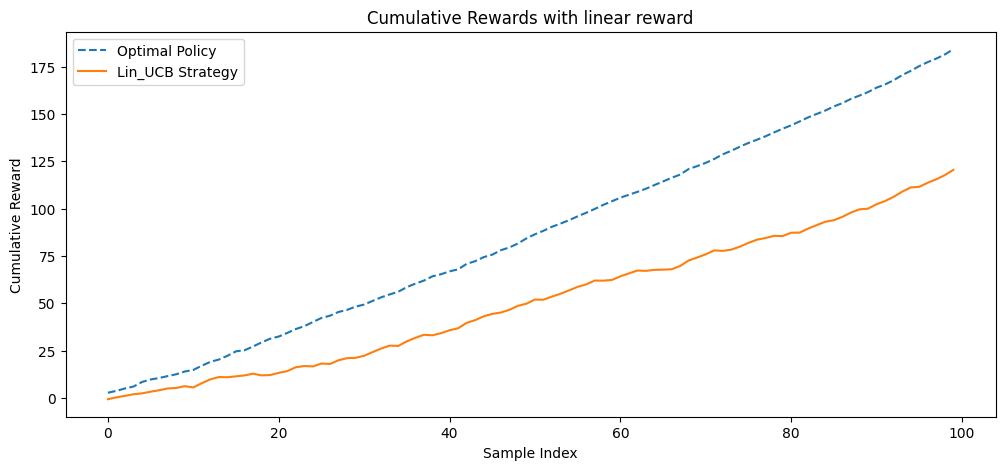

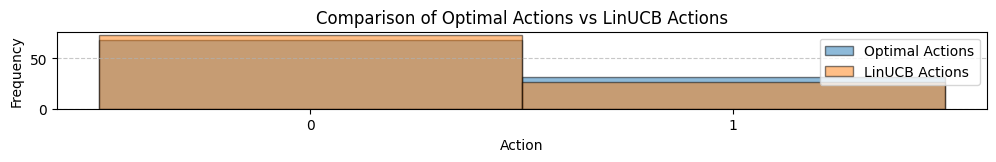

LinUCB Accuracy: 0.6100
LinUCB F1 Score: 0.6004


In [21]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50)

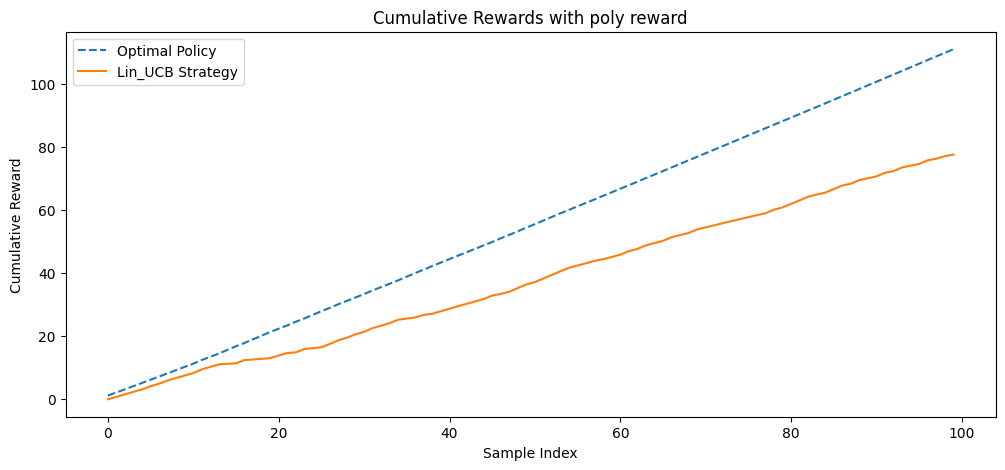

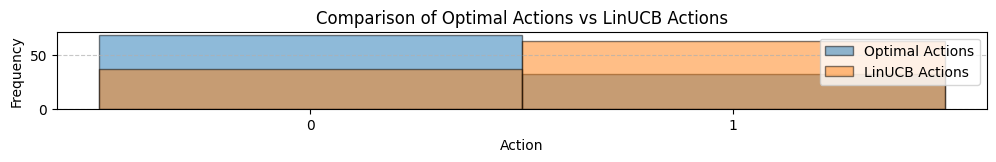

LinUCB Accuracy: 0.3100
LinUCB F1 Score: 0.3207


In [22]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50, reward_type = 'poly')

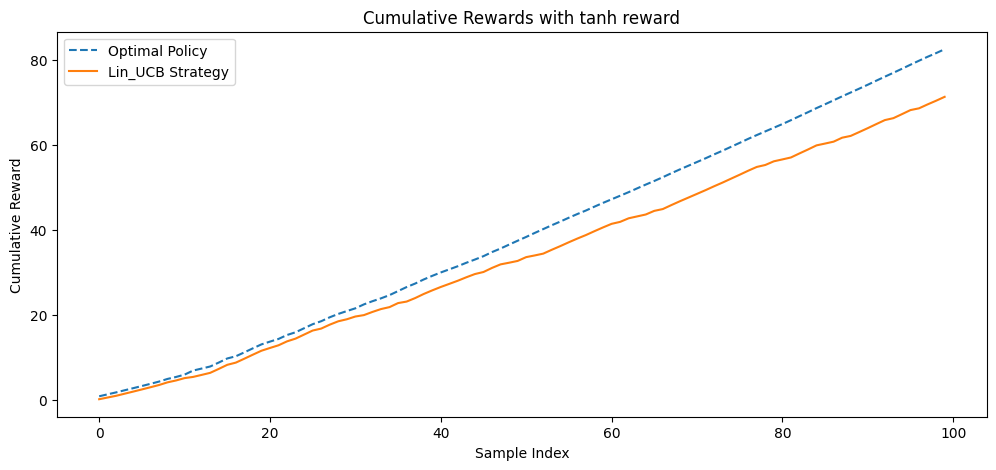

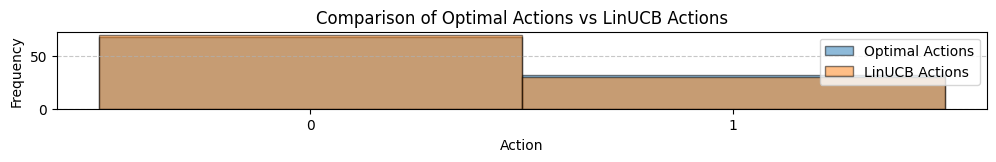

LinUCB Accuracy: 0.7600
LinUCB F1 Score: 0.7579


In [23]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50, reward_type = 'tanh')

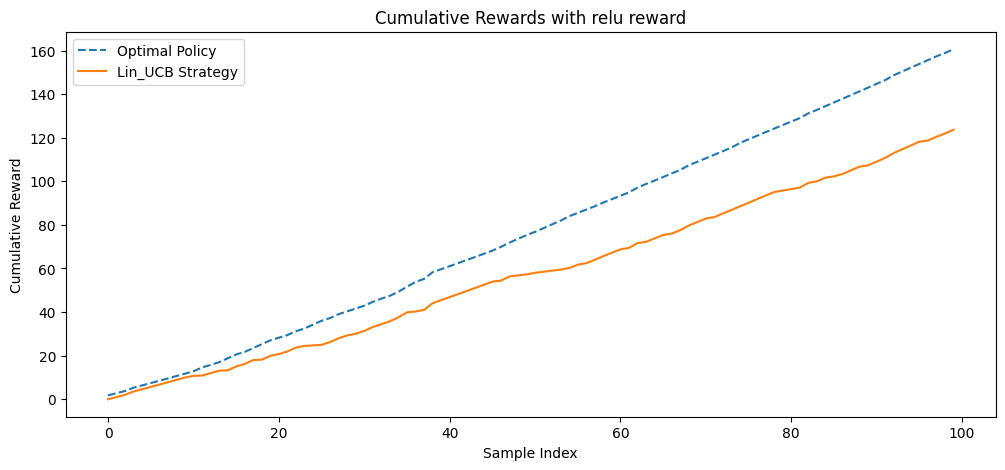

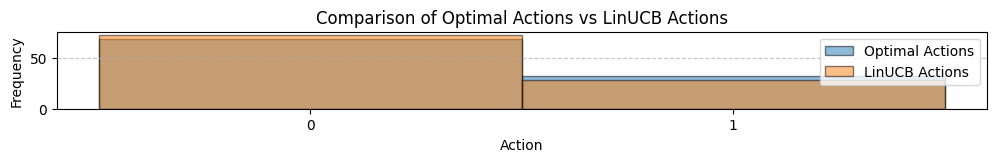

LinUCB Accuracy: 0.6600
LinUCB F1 Score: 0.6535


In [24]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50, reward_type = 'relu')

## 4. Doubly Robust

In [25]:
class LinUCB_DR:
    def __init__(self, n_actions, context_dim, alpha=0.5):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha
        self.A = [np.eye(context_dim) for _ in range(n_actions)]  # Identity matrices for each action
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]  # Zero vectors for each action
        self.propensities = None

    def calculate_propensity_scores(self, historical_actions):
        # Calculate propensity scores based on historical action frequencies
        total_samples = len(historical_actions)
        action_freq = np.bincount(historical_actions, minlength=self.n_actions) / total_samples
        self.propensities = action_freq[historical_actions]
        return self.propensities

    def update(self, action, reward, context):
        # Update A and b for the taken action
        self.A[action] += np.outer(context, context)
        self.b[action] += reward * context

    def predict(self, X):
        # Predict the reward for each action in the context X
        p = np.zeros((X.shape[0], self.n_actions))
        for a in range(self.n_actions):
            theta_a = np.linalg.solve(self.A[a], self.b[a])  # Solve A * theta = b
            p[:, a] = X @ theta_a + self.alpha * np.sqrt(np.sum(X @ np.linalg.inv(self.A[a]) * X, axis=1))
        return p

    def doubly_robust_estimator(self, X, chosen_actions, historical_rewards, historical_actions, all_true_rewards):
    # Calculate doubly robust reward estimates
        N = len(chosen_actions)
        dr_rewards = np.zeros(N)
        propensities = self.propensities if self.propensities is not None else self.calculate_propensity_scores(historical_actions)
        
        for i in range(N):
            Ai = chosen_actions[i]
            Ci = X[i]
            Ri = historical_rewards[i, historical_actions[i]]
            pi_ratio = propensities[chosen_actions[i]] / propensities[historical_actions[i]]

            predicted_reward = all_true_rewards[i, Ai]

            dr_rewards[i] = pi_ratio * (Ri - predicted_reward) + predicted_reward

        return dr_rewards


In [26]:
def run_backtest_DR(X, total_samples, n_actions, optimal_actions, context_dim, num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=20, reward_type='linear'):
    # Generate and split the dataset
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
        X, total_samples, n_actions, optimal_actions, reward_type)

    # Convert PyTorch tensors to NumPy arrays if needed
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().numpy()
    if isinstance(X_val, torch.Tensor):
        X_val = X_val.detach().numpy()
    if isinstance(historical_rewards, torch.Tensor):
        historical_rewards = historical_rewards.detach().numpy()
    if isinstance(historical_actions, torch.Tensor):
        historical_actions = historical_actions.detach().numpy()

    # Initialize LinUCB_DR model
    lin_UCB_DR_model = LinUCB_DR(n_actions, context_dim, alpha=0.5)
    lin_UCB_DR_model.calculate_propensity_scores(historical_actions)  # Calculate propensities internally

    # Update the model with historical data
    for i in range(len(historical_actions)):
        lin_UCB_DR_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])

    # Generate predictions on validation data
    lin_UCB_preds = lin_UCB_DR_model.predict(X_val)
    lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)

    # Generate true rewards based on optimal actions
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    reward_gen = RewardGenerator()
    
    for action in range(n_actions):
        for i, opt_action in enumerate(optimal_actions_val):
            if reward_type == 'linear':
                all_true_rewards[i, action] = reward_gen.generate_rewards(X_val[i], action, opt_action)
            elif reward_type == 'poly':
                all_true_rewards[i, action] = reward_gen.generate_rewards_polynomial(X_val[i], action, opt_action)
            elif reward_type == 'tanh':
                all_true_rewards[i, action] = reward_gen.generate_rewards_tanh(X_val[i], action, opt_action)
            elif reward_type == 'relu':
                all_true_rewards[i, action] = reward_gen.generate_rewards_relu(X_val[i], action, opt_action)

    # Calculate doubly robust rewards
    dr_rewards = lin_UCB_DR_model.doubly_robust_estimator(X_val, lin_UCB_preds, historical_rewards, historical_actions, all_true_rewards)

    # Plot cumulative rewards
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(np.max(all_true_rewards, axis=1)), label='Optimal Policy', linestyle='--')
    plt.plot(np.cumsum(dr_rewards), label='LinUCB_DR Strategy')

    plt.title(f'Cumulative Rewards with {reward_type} reward (Doubly Robust)')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()

    # Plot optimal vs LinUCB_DR predicted actions
    plot_optimal_vs_linucb(optimal_actions_val, lin_UCB_preds)

    # Print evaluation metrics
    print(f"LinUCB_DR Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
    print(f"LinUCB_DR F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")


In [27]:
# Example usage
X=df2.values
total_samples = X.shape[0]
n_actions = 2
context_dim =X.shape[1]   # Number of context features
optimal_actions=y

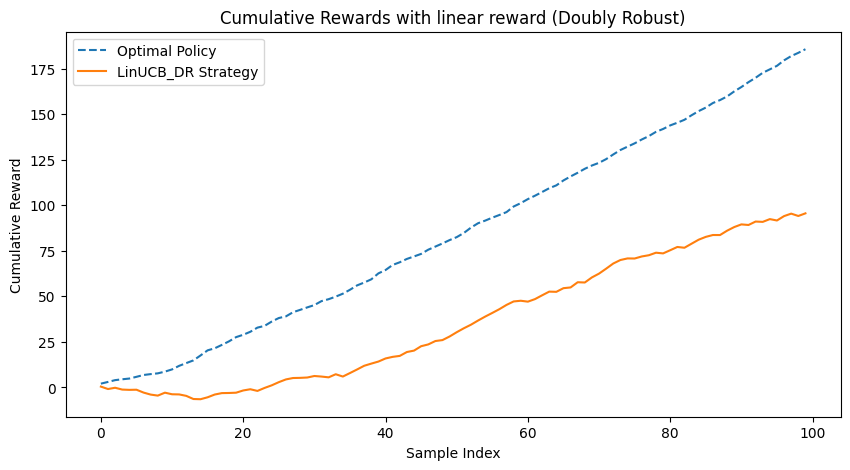

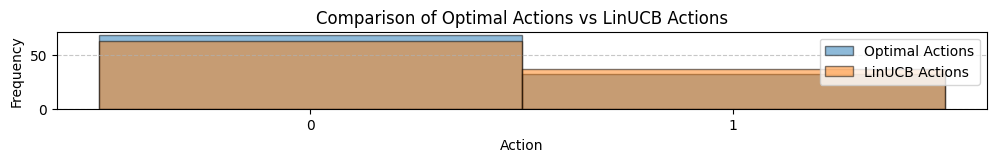

LinUCB_DR Accuracy: 0.5700
LinUCB_DR F1 Score: 0.5774


In [28]:
run_backtest_DR(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50)

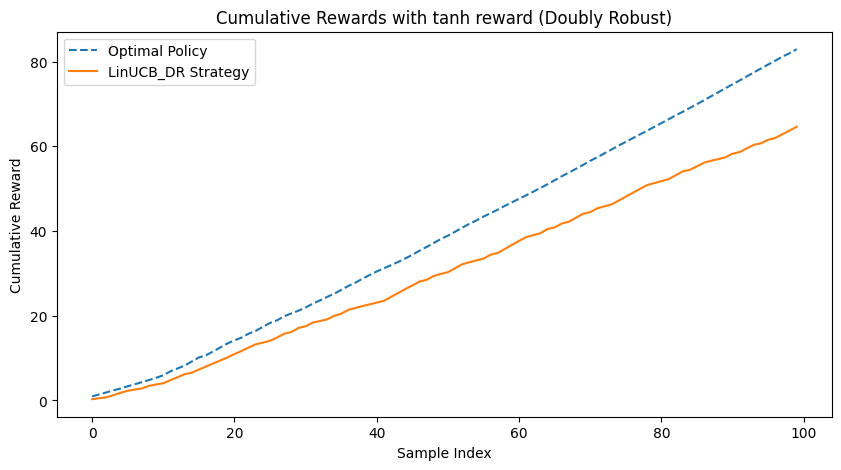

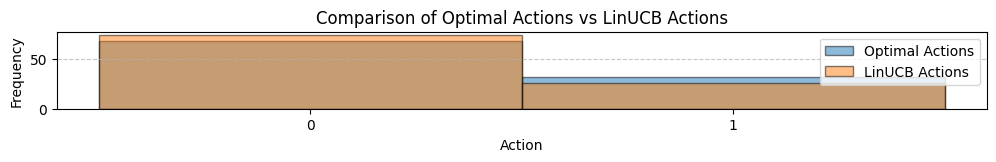

LinUCB_DR Accuracy: 0.7600
LinUCB_DR F1 Score: 0.7527


In [29]:
run_backtest_DR(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50, reward_type = 'tanh')

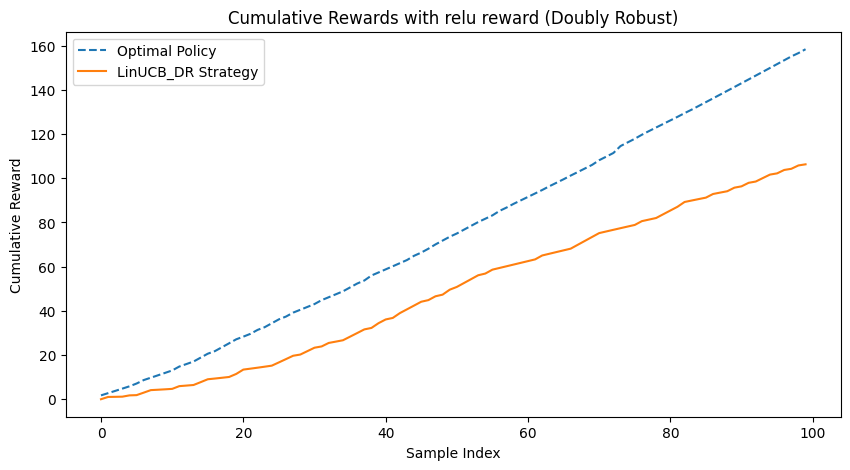

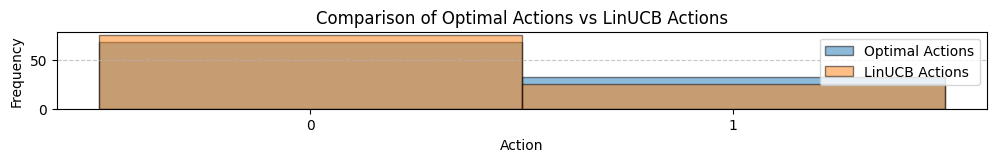

LinUCB_DR Accuracy: 0.7100
LinUCB_DR F1 Score: 0.6993


In [30]:
run_backtest_DR(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50, reward_type = 'relu')

In [31]:
def run_backtest_with_alpha(X, total_samples, n_actions, optimal_actions, context_dim, reward_type='linear', alpha_values=[0.1, 0.5, 1.0], epochs=20):
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
        X, total_samples, n_actions, optimal_actions, reward_type)

    # Convert PyTorch tensors to NumPy arrays if needed
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().numpy()
    if isinstance(X_val, torch.Tensor):
        X_val = X_val.detach().numpy()
    if isinstance(historical_rewards, torch.Tensor):
        historical_rewards = historical_rewards.detach().numpy()
    if isinstance(historical_actions, torch.Tensor):
        historical_actions = historical_actions.detach().numpy()
    
    # Initialize reward generator for the test set
    reward_gen = RewardGenerator()

    # Generate true rewards based on optimal actions
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    
    for action in range(n_actions):
        for i, opt_action in enumerate(optimal_actions_val):
            if reward_type == 'linear':
                all_true_rewards[i, action] =  reward_gen.generate_rewards(X_val[i], action, opt_action)
            elif reward_type == 'tanh':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_tanh(X_val[i], action, opt_action)
            
    true_rewards = np.max(all_true_rewards, axis=1)
    
    # Plot cumulative rewards for each alpha
    plt.figure(figsize=(12, 6))
    
    for alpha in alpha_values:
        # LinUCB with different alphas
        lin_UCB_model = LinUCB(n_actions, context_dim, alpha=alpha)
        
        # Train LinUCB model
        for i in range(len(historical_actions)):
            lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])
        
        # Predict with LinUCB on validation set
        lin_UCB_preds = lin_UCB_model.predict(X_val)
        lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
        
        # Calculate rewards from LinUCB strategy
        lin_UCB_rewards = np.array([all_true_rewards[i, lin_UCB_preds[i]] for i in range(len(lin_UCB_preds))])
        
        # Plot cumulative rewards for this alpha
        plt.plot(np.cumsum(lin_UCB_rewards), label=f'LinUCB (alpha={alpha})')

    # Plot cumulative rewards of the optimal policy
    plt.plot(np.cumsum(true_rewards), label='Optimal Policy', linestyle='--', color='black')
    
    plt.title(f'Cumulative Rewards with {reward_type} reward')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the accuracy and F1 score for the final comparison (optional)
    for alpha in alpha_values:
        lin_UCB_model = LinUCB(n_actions, context_dim, alpha=alpha)
        for i in range(len(historical_actions)):
            lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])
        
        lin_UCB_preds = lin_UCB_model.predict(X_val)
        lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
        
        print(f"Alpha: {alpha}")
        print(f"LinUCB Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
        print(f"LinUCB F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")
        print("\n")

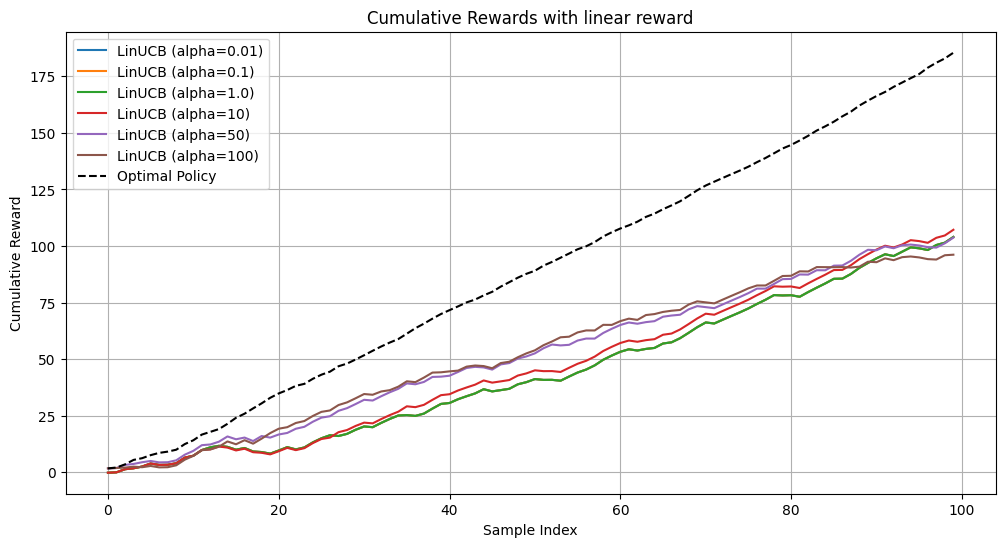

Alpha: 0.01
LinUCB Accuracy: 0.5900
LinUCB F1 Score: 0.5799


Alpha: 0.1
LinUCB Accuracy: 0.5900
LinUCB F1 Score: 0.5799


Alpha: 1.0
LinUCB Accuracy: 0.5900
LinUCB F1 Score: 0.5799


Alpha: 10
LinUCB Accuracy: 0.5600
LinUCB F1 Score: 0.5634


Alpha: 50
LinUCB Accuracy: 0.4200
LinUCB F1 Score: 0.4200


Alpha: 100
LinUCB Accuracy: 0.3100
LinUCB F1 Score: 0.2352




In [32]:
alpha_values = [0.01, 0.1, 1.0, 10, 50, 100]
run_backtest_with_alpha(X, total_samples=1000, n_actions=2, optimal_actions=optimal_actions, context_dim=X.shape[1], reward_type='linear', alpha_values=alpha_values)

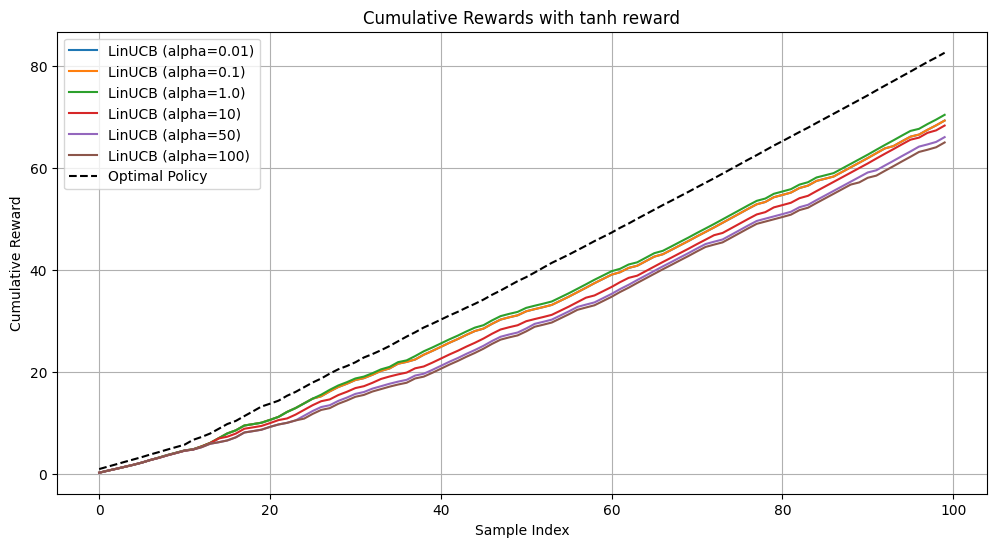

Alpha: 0.01
LinUCB Accuracy: 0.7300
LinUCB F1 Score: 0.7200


Alpha: 0.1
LinUCB Accuracy: 0.7300
LinUCB F1 Score: 0.7200


Alpha: 1.0
LinUCB Accuracy: 0.7600
LinUCB F1 Score: 0.7460


Alpha: 10
LinUCB Accuracy: 0.7400
LinUCB F1 Score: 0.6900


Alpha: 50
LinUCB Accuracy: 0.6700
LinUCB F1 Score: 0.6287


Alpha: 100
LinUCB Accuracy: 0.6500
LinUCB F1 Score: 0.6061




In [33]:
alpha_values = [0.01, 0.1, 1.0, 10, 50, 100]
run_backtest_with_alpha(X, total_samples=1000, n_actions=2, optimal_actions=optimal_actions, context_dim=X.shape[1], reward_type='tanh', alpha_values=alpha_values)